## Softmax Regression
1. [读取数据](#读取数据)
2. [画出数字](#画出数字)
3. [构建模型](#构建模型)
4. [固定学习率训练模型](#固定学习率训练模型)
4. [使用scipy.optimize优化算法训练](#使用scipy.optimize优化算法训练)
4. [使用theano.printing画出computation graph](#cg)

In [1]:
%pylab inline
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T
import scipy.io as sio
import time

/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 0 failed:
cublasCreate() returned this error 'the CUDA Runtime initialization failed'
ERROR:theano.sandbox.cuda:ERROR: Not using GPU. Initialisation of device 0 failed:
cublasCreate() returned this error 'the CUDA Runtime initialization failed'


Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)


### 读取数据

In [2]:
data = sio.loadmat('ex3data1.mat')
X = data['X'].astype('float32') # (5000, 400)
Y = data['y'] # (5000, 1)
Y = Y * (Y != 10) # 替换10为0
Y = Y.reshape(5000, )
m, n = X.shape
num_labels = 10 # 10个类别

### 画出数字

In [3]:
def displayData(X, example_width=-1):
    if example_width == -1:
        example_width = np.round(np.sqrt(X.shape[1])).astype('int8')
    # 计算每个小图的宽高
    m, n = X.shape
    example_height = (n / example_width)
    
    # 计算整个大拼图的宽高
    display_rows = np.floor(np.sqrt(m))
    display_cols = np.ceil(m / display_rows)
    
    #  小图之间的间隙
    pad = 1

    # 初始化大图矩阵
    display_array = -np.ones([pad + display_rows * (example_height + pad), pad + display_cols * (example_width + pad)])
    # 装填图像矩阵
    curr_ex = 0
    for j in np.arange(display_rows):
        for i in np.arange(display_cols):
            if curr_ex >= m:
                break
            max_val = np.max(np.abs(X[curr_ex, :]))
            offset_row = int(pad + j * (example_height + pad))
            offset_col = int(pad + i * (example_width + pad))
            display_array[offset_row : offset_row + example_height,
                                     offset_col : offset_col + example_width] = np.reshape(X[curr_ex, :], [20, 20], order='F') / max_val # 按照Fortran顺序reshape(matlab也是按F顺序),或者按照默认的C顺序,然后转置
            curr_ex += 1
        if curr_ex >= m:
            break
    plt.imshow(display_array, cmap=plt.cm.binary_r)
    

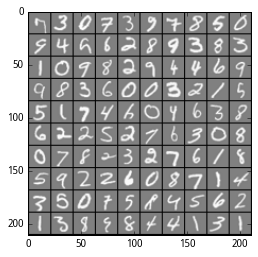

In [4]:
# 随机选择100个数字显示
idx_rand = np.arange(X.shape[0])
np.random.shuffle(idx_rand)
sel = X[idx_rand[0:100], :]
displayData(sel)

In [5]:
# 添加一列1
ones = np.ones([5000, 1], dtype='float32')
X = np.concatenate([ones, X], axis=1) # (5000, 401)

### 构建模型

In [13]:
grad.eval({y: Y}).dtype

dtype('float64')

In [15]:
x = theano.shared(X, name = 'x') # (5000, 401)
#y = theano.shared(Y, name = 'y')  # (5000, 1) 
y = T.ivector(name='y') # y是int类型,放入shared会使程序变慢很多 ,这样稍微比直接使用y好一点: yy = theano.shared(Y, name = 'y')  # (5000, 1),   y = T.cast(yy, 'int32')
gy = T.zeros([5000, 10], dtype='int32') # (5000, 10)
gyy = T.set_subtensor(gy[T.arange(5000), y[:]], 1) # 转成one-hot representation，表示类别
theta = theano.shared(np.zeros([n + 1, num_labels], dtype='float32')) # (401, 10) 参数
alpha = T.scalar('alpha') # 学习率

temp = x.dot(theta) # (5000, 10)
pre_prob = T.nnet.softmax(temp)
loss = -T.log(pre_prob[T.arange(x.shape[0]), y[:]]).mean()

grad = T.cast(T.dot(x.T, pre_prob - gyy) / x.shape[0], 'float32') # (401, 10) # 手动求导
grad_auto = T.grad(loss, theta)
gradient_step = theano.function([alpha, y],updates={theta : theta - alpha * grad})
gradient_step_auto = theano.function([alpha, y],updates={theta : theta - alpha * grad_auto}) # 梯度下降更新参数
calcGradAuto = theano.function([y], grad_auto)
calcGrad = theano.function([y], grad)
calcLoss = theano.function([y], loss)

In [16]:
# 模型预测
preIndex =  T.argmax(pre_prob, axis=1) # (5000,) 预测结果
total = T.eq(y.T, preIndex)
accuracy = total.sum() / float(m) # 准确率
calcAccur = theano.function([y], accuracy)

### 固定学习率训练模型

In [18]:
# 固定学习率, 训练模型, 计算耗时和准确率， 纯梯度下降的准确率低
theta.set_value(np.zeros([n + 1, num_labels], dtype='float32')) # (401, 10)
max_iters = 1000
lambdaInit = 1
alphaVal = 0.01
J_history = np.zeros((max_iters, 1))
start_time = time.time()
for i in range(max_iters):
    #print 'a'
    gradient_step_auto(alphaVal, Y)
end_time = time.time()
print 'training cost %.2f s' % (end_time - start_time)
print 'training set accuracy is %.2f ' % (calcAccur(Y))

training cost 7.67 s
training set accuracy is 0.85 


### 使用scipy.optimize优化算法训练

In [19]:
# 计算指定theta时的cost,使用optimize的函数时,传入的待优化参数是一个一维向量,所以要转成二维列向量,并且使用fmin时还需要转成float32类型
def computeCost(theta_value):
    theta.set_value(theta_value.reshape(n + 1, num_labels).astype('float32'))
    return calcLoss(Y)

# 计算指定theta时的梯度
def train_fn_grad(theta_value):
    theta.set_value(theta_value.reshape(n + 1, num_labels).astype('float32'))
    return np.array(calcGrad(Y)).flatten() # 梯度也要转为一维向量


def fitModel():
    # 使用共轭梯度法优化
    thetaV = [] # 存储每一次迭代后的结果
    thetaValue = optimize.fmin_cg( # or fmin_bfgs
        f=computeCost,
        x0=np.zeros([n + 1, num_labels], dtype='float32'),
        fprime=train_fn_grad,
        disp=1,
        maxiter=1000,
        callback=lambda t : thetaV.append(t.reshape(n + 1, num_labels))
    )
    return thetaValue, thetaV


In [20]:
from scipy import optimize
start_time = time.time()
thetaValue, thetaV = fitModel()
end_time = time.time()
print 'training cost %.2f s' % (end_time - start_time)
theta.set_value(thetaValue.reshape(401,10).astype('float32'))
print 'training set accuracy is %.2f ' % (calcAccur(Y)) # 100%

Optimization terminated successfully.
         Current function value: 0.006387
         Iterations: 850
         Function evaluations: 4172
         Gradient evaluations: 4172
training cost 57.00 s
training set accuracy is 1.00 


### 使用theano.printing画出computation graph<span id='cg'/>

In [21]:
theano.printing.debugprint(gradient_step_auto)

GpuGemm{inplace} [id A] ''   26
 |<CudaNdarrayType(float32, matrix)> [id B]
 |HostFromGpu [id C] ''   12
 | |GpuElemwise{Neg}[(0, 0)] [id D] ''   9
 |   |GpuFromHost [id E] ''   4
 |     |alpha [id F]
 |GpuDimShuffle{1,0} [id G] ''   3
 | |x [id H]
 |GpuDimShuffle{0,1} [id I] ''   25
 | |GpuDnnSoftmaxGrad{tensor_format='bc01', mode='channel', algo='accurate'} [id J] ''   24
 |   |GpuContiguous [id K] ''   23
 |   | |GpuDimShuffle{0,1,x,x} [id L] ''   22
 |   |   |GpuFromHost [id M] ''   21
 |   |     |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=False} [id N] ''   20
 |   |       |Alloc [id O] ''   8
 |   |       | |TensorConstant{(1, 1) of 0.0} [id P]
 |   |       | |Shape_i{0} [id Q] ''   2
 |   |       | | |x [id H]
 |   |       | |Shape_i{1} [id R] ''   0
 |   |       |   |<CudaNdarrayType(float32, matrix)> [id B]
 |   |       |Elemwise{TrueDiv}[(0, 1)] [id S] ''   19
 |   |       | |Elemwise{Composite{(i0 / Cast{float32}(i1))}} [id T] ''   11
 |   |       | | |TensorCon

In [22]:
theano.printing.pydotprint(gradient_step_auto, outfile="aa.png", var_with_name_simple=True)   ### 输出图像

The output file is available at aa.png


![sdf](aa.png)

In [23]:
import theano.d3viz as d3v # 生成可交互的computational graph(Html 形式)

In [24]:
d3v.d3viz(calcLoss, 'mlp.html')